# Decision Tree Implementation from Scratch

## Overview

이 노트북에서는 결정 트리(Decision Tree) 알고리즘을 처음부터 구현합니다. 결정 트리는 다음과 같은 특징을 가진 지도 학습 알고리즘입니다:

- 분류(Classification)와 회귀(Regression) 문제 모두에 사용 가능
- 비선형 관계를 모델링할 수 있음
- 데이터를 특성 공간에서 계층적으로 분할하는 방식으로 작동
- 결과가 해석하기 쉽고 시각화 가능

## 구현 과정

1. 노드(Node) 클래스 구현
2. 분할 기준 함수 구현 (정보 이득, 지니 불순도 등)
3. 최적 분할 지점 찾기 알고리즘 구현
4. 재귀적 트리 성장 알고리즘 구현
5. 예측 함수 구현
6. 트리 시각화 함수 구현
7. 가지치기(Pruning) 알고리즘 구현

## 수학적 배경

결정 트리는 다음과 같은 수학적 개념을 활용합니다:

- **엔트로피(Entropy)**: 데이터의 무질서도를 측정
- **정보 이득(Information Gain)**: 분할 전후의 엔트로피 차이
- **지니 불순도(Gini Impurity)**: 무작위로 선택한 샘플이 잘못 분류될 확률
- **분산 감소(Variance Reduction)**: 회귀 문제에서 사용되는 분할 기준


In [1]:
# 필요한 라이브러리 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.datasets import load_iris, fetch_california_housing
from sklearn.model_selection import train_test_split

# 시각화를 위한 설정
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 8)
plt.style.use('ggplot')

# 0. 1-Depth Decision Tree
- 구조: 루트 노드 한 개 + 두 개의 리프 노드 => 한 번만 분기하는 구조

In [ ]:
import numpy as np
from collections import Counter

class TinyDecisionTree:
    def __init__(self):
        ''' 
        Initialize the tree structure.
        '''
        self.feature_idx = None        # index of feature to split on
        self.threshold = None          # split threshold value
        self.left_class = None         # prediction if feature <= threshold
        self.right_class = None        # prediction if feature > threshold

    def gini(self, labels):
        '''
        Compute Gini impurity for a list of class labels.
        '''
        counts = Counter(labels)
        total = sum(counts.values())
        probs = [count / total for count in counts.values()]
        gini_impurity = 1.0 - sum(p ** 2 for p in probs)
        return gini_impurity

    def most_common_class(self, labels):
        '''
        Return the most frequent class label from labels.
        '''
        return Counter(labels).most_common(1)[0][0]

    def fit(self, X, y):
        '''
        Train the tree by finding the best split across all features and thresholds.
        '''
        best_gini = 1.0
        best_feature = None
        best_threshold = None

        # Try every feature 
        for feature_idx in range(X.shape[1]):
            # Use unique values in that feature as candidate thresholds (실제 존재하는 값으로 임계값을 하나씩 적용해보기)
            thresholds = np.unique(X[:, feature_idx])
            for threshold in thresholds:
                
                # Split y into left and right groups
                left_mask = X[:, feature_idx] <= threshold  #boolean mask, if True sent to left
                right_mask = ~left_mask  #not operator, 즉 나머지를 오른쪽으로 보냄

                left_y = y[left_mask]
                right_y = y[right_mask]

                # Skip if one side is empty: 왼/오 그룹 각각에 데이터가 하나도 없으면 gini impurity 계산이 불가능 하기에 무효
                if len(left_y) == 0 or len(right_y) == 0:
                    continue  # 현재 반복을 중단하고 다음 반복으로 바로 넘어감

                # === 이 아래는 if 조건이 False일 때만 실행됨 ===
                
                # Compute weighted Gini impurity
                # Formula: Gini = 1 - sum(p_i^2), where p_i is the proportion of each class
                # 한 클래스만 있음 = 순수 = impurity가 작아짐
                total = len(y)
                gini_left = self.gini(left_y)
                gini_right = self.gini(right_y)

                # weighted gini impurity: 각 그룹의 순수도를 측정하되, 그룹의 크기를 가중평균
                weighted_gini = (len(left_y) / total) * gini_left + (len(right_y) / total) * gini_right

                # Update best split if improvement
                # 여러 후보 중에서 가장 Gini impurity가 낮은 분할을 이번 분기의 규칙으로 저장
                if weighted_gini < best_gini:
                    best_gini = weighted_gini
                    best_feature = feature_idx
                    best_threshold = threshold

        # Store best split
        self.feature_idx = best_feature
        self.threshold = best_threshold

        # Store prediction for each split side
        left_mask = X[:, self.feature_idx] <= self.threshold
        right_mask = ~left_mask

        self.left_class = self.most_common_class(y[left_mask])  #LEFT에서 가장 빈출한 클래스
        # self.left_class = Counter(y[left_mask]).most_common(1)[0][0]  
        self.right_class = self.most_common_class(y[right_mask])  #RIGHT에서 가장 빈출한 클래스
        # self.right_class = Counter(y[right_mask]).most_common(1)[0][0]  

    def predict(self, X):
        '''
        Predict class labels for given input X.
        '''
        # Vectorized prediction using np.where
        return np.where(
            X[:, self.feature_idx] <= self.threshold,
            self.left_class,
            self.right_class
        )

In [25]:
import numpy as np

# 예시 데이터 (2차원 특징, 2개의 클래스)
# 예: 꽃받침 길이, 꽃잎 길이
X = np.array([
    [5.1, 1.4],
    [4.9, 1.5],
    [6.0, 4.5],
    [6.1, 4.7],
    [5.0, 1.3],
    [6.2, 4.6],
])

# 클래스 라벨 (0 = 작고 짧은 꽃, 1 = 크고 길쭉한 꽃)
y = np.array([0, 0, 1, 1, 0, 1])

# TinyDecisionTree 클래스는 위에서 이미 정의되어 있다고 가정

# 모델 생성 및 학습
model = TinyDecisionTree()
model.fit(X, y)

# 테스트용 입력값
X_test = np.array([
    [5.0, 1.2],  # 예상: class 0
    [6.3, 4.9],  # 예상: class 1
    [5.5, 2.0],  # 중간 정도 — threshold에 따라 달라질 수 있음
])

# 예측 실행
predictions = model.predict(X_test)

# 결과 출력
print("Test Inputs:")
print(X_test)
print("Predicted Classes:")
print(predictions)

Test Inputs:
[[5.  1.2]
 [6.3 4.9]
 [5.5 2. ]]
Predicted Classes:
[0 1 1]


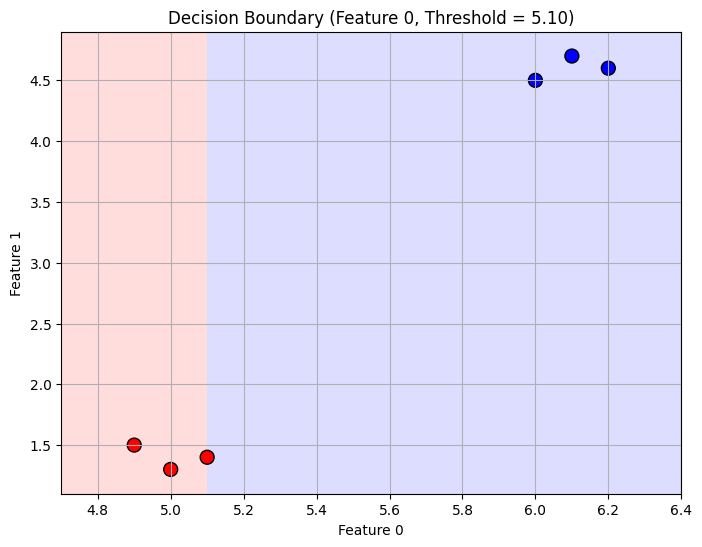

In [26]:
# 학습된 TinyDecisionTree 모델이 기준으로 하는 결정경계를 시각화하는 코드

def plot_decision_boundary(model, X, y):
    from matplotlib.colors import ListedColormap
    import matplotlib.pyplot as plt

    cmap_bg = ListedColormap(['#FFAAAA', '#AAAAFF'])  # 배경색: class 0 / class 1
    cmap_pts = ListedColormap(['#FF0000', '#0000FF'])  # 점 색: class 0 / class 1

    x_min, x_max = X[:, 0].min() - 0.2, X[:, 0].max() + 0.2
    y_min, y_max = X[:, 1].min() - 0.2, X[:, 1].max() + 0.2
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))

    # 평면상의 모든 점에 대해 예측
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid).reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=cmap_bg, alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_pts, edgecolor='k', s=100)
    plt.title(f"Decision Boundary (Feature {model.feature_idx}, Threshold = {model.threshold:.2f})")
    plt.xlabel("Feature 0")
    plt.ylabel("Feature 1")
    plt.grid(True)
    plt.show()

# 위에서 사용한 학습 데이터 기준으로 다시 그림
plot_decision_boundary(model, X, y)

# 1. Recursive Decision Tree
    - 사용자가 지정한 깊이까지만 재귀적으로 분기 가능
    - 예: max_depth=2면 → 루트에서 한 번 분기 → 그 하위에서 또 한 번 분기
    - max_depth=1이면 → 지금의 TinyDecisionTree와 동일한 1-depth 트리

In [ ]:
import numpy as np
from collections import Counter

class RecursiveDecisionTree:
    def __init__(self, depth=0, max_depth=1):
        '''
        Initialize a tree node with depth control.
        '''
        self.depth = depth                    # Current depth of the node
        self.max_depth = max_depth            # Maximum allowable depth
        self.feature_idx = None               # Feature index to split on
        self.threshold = None                 # Threshold value for split
        self.left = None                      # Left child node
        self.right = None                     # Right child node
        self.predicted_class = None           # Prediction stored at leaf node
        self.class_counts = None              # Class counts at leaf node for predict_proba

    def gini(self, labels):
        '''
        Compute Gini impurity for a list of class labels.
        '''
        counts = Counter(labels)              # Count occurrences of each class
        total = sum(counts.values())
        probs = [count / total for count in counts.values()]  # Convert to probabilities
        return 1.0 - sum(p ** 2 for p in probs)  # Gini impurity formula

    def most_common_class(self, labels):
        '''
        Return the most frequent class label from the input.
        '''
        return Counter(labels).most_common(1)[0][0]

    def fit(self, X, y):
        '''
        Recursively fit the decision tree using best Gini split, stopping at max_depth.
        '''
        if self.depth >= self.max_depth or len(set(y)) == 1:
            # Stopping condition: max depth reached or labels are pure
            self.predicted_class = self.most_common_class(y)
            self.class_counts = Counter(y)  # Save counts for proba calculation
            return

        best_gini = 1.0
        best_feature = None
        best_threshold = None

        # Iterate through all features and thresholds to find best split
        for feature_idx in range(X.shape[1]):
            thresholds = np.unique(X[:, feature_idx])
            for threshold in thresholds:
                left_mask = X[:, feature_idx] <= threshold
                right_mask = ~left_mask

                left_y = y[left_mask]
                right_y = y[right_mask]

                if len(left_y) == 0 or len(right_y) == 0:
                    continue  # Skip invalid split

                gini_left = self.gini(left_y)
                gini_right = self.gini(right_y)

                weighted_gini = (len(left_y) / len(y)) * gini_left + \
                                 (len(right_y) / len(y)) * gini_right

                # Update best split if this is better
                if weighted_gini < best_gini:
                    best_gini = weighted_gini
                    best_feature = feature_idx
                    best_threshold = threshold

        if best_feature is None:
            # No valid split found; become a leaf node
            self.predicted_class = self.most_common_class(y)
            self.class_counts = Counter(y)
            return

        # Save the best split found
        self.feature_idx = best_feature
        self.threshold = best_threshold

        # Split the data and create child nodes
        left_mask = X[:, self.feature_idx] <= self.threshold
        right_mask = ~left_mask

        # 각 서브그룹에 대해 새로운 TreeNode를 생성하고 재귀적으로 분기
        self.left = RecursiveDecisionTree(depth=self.depth + 1, max_depth=self.max_depth)
        self.left.fit(X[left_mask], y[left_mask])

        self.right = RecursiveDecisionTree(depth=self.depth + 1, max_depth=self.max_depth)
        self.right.fit(X[right_mask], y[right_mask])

    def predict_one(self, x):
        '''
        Predict a single sample x by traversing the tree.
        '''
        if self.predicted_class is not None:
            return self.predicted_class  # Leaf node
        if x[self.feature_idx] <= self.threshold:
            return self.left.predict_one(x)  # Traverse left
        else:
            return self.right.predict_one(x)  # Traverse right

    def predict(self, X):
        '''
        Predict labels for a batch of samples.
        '''
        return np.array([self.predict_one(x) for x in X])

    def predict_proba_one(self, x):
        '''
        Return class probability distribution for one sample.
        '''
        if self.predicted_class is not None:
            total = sum(self.class_counts.values())
            return {cls: count / total for cls, count in self.class_counts.items()}
        if x[self.feature_idx] <= self.threshold:
            return self.left.predict_proba_one(x)
        else:
            return self.right.predict_proba_one(x)

    def predict_proba(self, X):
        '''
        Return class probabilities for a batch of samples.
        '''
        return [self.predict_proba_one(x) for x in X]

In [29]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import numpy as np

# 1. 데이터 불러오기
iris = load_iris()
X = iris.data               # (150, 4): 꽃받침 길이, 꽃잎 길이 등 4개의 피처
y = iris.target             # 클래스: 0=setosa, 1=versicolor, 2=virginica

# 2. 학습/테스트 나누기
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(X_train.shape, X_test.shape)  # 확인용

# 3. 모델 학습
tree = RecursiveDecisionTree(max_depth=3)
tree.fit(X_train, y_train)

# 4. 예측 및 확률 출력
y_pred = tree.predict(X_test)
y_proba = tree.predict_proba(X_test)

# 5. 결과 출력
print("Predicted Classes:")
print(y_pred)
print("\nPredicted Probabilities:")
for i, prob in enumerate(y_proba):
    print(f"Sample {i}: {prob}")

from sklearn.metrics import accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred))    

(120, 4) (30, 4)
Predicted Classes:
[1 0 2 1 2 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0]

Predicted Probabilities:
Sample 0: {1: 1.0}
Sample 1: {0: 1.0}
Sample 2: {2: 0.9714285714285714, 1: 0.02857142857142857}
Sample 3: {1: 1.0}
Sample 4: {2: 0.5, 1: 0.5}
Sample 5: {0: 1.0}
Sample 6: {1: 1.0}
Sample 7: {2: 0.9714285714285714, 1: 0.02857142857142857}
Sample 8: {1: 1.0}
Sample 9: {1: 1.0}
Sample 10: {2: 0.9714285714285714, 1: 0.02857142857142857}
Sample 11: {0: 1.0}
Sample 12: {0: 1.0}
Sample 13: {0: 1.0}
Sample 14: {0: 1.0}
Sample 15: {1: 1.0}
Sample 16: {2: 0.9714285714285714, 1: 0.02857142857142857}
Sample 17: {1: 1.0}
Sample 18: {1: 1.0}
Sample 19: {2: 0.9714285714285714, 1: 0.02857142857142857}
Sample 20: {0: 1.0}
Sample 21: {2: 0.9714285714285714, 1: 0.02857142857142857}
Sample 22: {0: 1.0}
Sample 23: {2: 0.9714285714285714, 1: 0.02857142857142857}
Sample 24: {2: 0.9714285714285714, 1: 0.02857142857142857}
Sample 25: {2: 0.9714285714285714, 1: 0.02857142857142857}
Sample 

## 1. 노드 클래스 구현

결정 트리는 노드들의 계층 구조로 이루어져 있습니다. 각 노드는 트리의 기본 구성 요소입니다.

### 1.1 노드의 기본 구조

노드는 다음과 같은 기본 정보를 저장해야 합니다:

- `feature_idx`: 분할에 사용된 특성의 인덱스
- `threshold`: 분할 기준값
- `left`: 왼쪽 자식 노드 (feature_value <= threshold인 경우)
- `right`: 오른쪽 자식 노드 (feature_value > threshold인 경우)
- `is_leaf`: 리프 노드 여부

In [ ]:
# import numpy as np

# y = np.array([0, 1, 1, 0, 2, 1, 2, 2, 2, 2, 2])

# counts = np.bincount(y)
# print(counts)  # 출력: [2 3 4]

# probs = counts / counts.sum()
# print(probs) 

# # gini impurity 
# gini_impurity = 1.0 - np.sum(probs ** 2)
# print(gini_impurity)

from collections import Counter

total = len(y)
counts = Counter(y)
# print(total, counts)

# compute class probs
probs = [count / total for count in counts.values()]

# compute gini impurity 
# Formula: Gini = 1 - sum(p_i^2), where p_i is the proportion of each class
impurity = 1.0 - sum(p ** 2 for p in probs)


print(probs, impurity)

[0.18181818181818182, 0.2727272727272727, 0.5454545454545454] 0.5950413223140496


### 1.2 예측 관련 정보

노드가 예측에 사용할 정보도 저장해야 합니다:

- `value`: 노드의 예측값 (리프 노드인 경우)
- `class_distribution`: 분류 문제에서 클래스별 샘플 수 (Counter 객체 등)
- `n_samples`: 해당 노드에 도달한 샘플 수

In [ ]:
class DecisionTree()

## 2. 분할 기준 함수 구현

트리의 각 노드에서는 데이터를 분할하는 기준이 필요합니다. 분류 문제에서는 주로 엔트로피와 지니 불순도를, 회귀 문제에서는 MSE(평균 제곱 오차)를 사용합니다.

### 2.1 엔트로피(Entropy) 계산

엔트로피는 데이터의 무질서도를 측정하는 지표로, 다음 수식으로 계산합니다:

$$H(S) = -\sum_{i=1}^{c} p_i \log_2 p_i$$

여기서 $p_i$는 클래스 $i$의 비율입니다.

아래 셀에 엔트로피 계산 함수를 구현해보세요.

### 2.2 지니 불순도(Gini Impurity) 계산

지니 불순도는 무작위로 선택한 샘플이 잘못 분류될 확률로, 다음 수식으로 계산합니다:

$$G(S) = 1 - \sum_{i=1}^{c} p_i^2$$

여기서 $p_i$는 클래스 $i$의 비율입니다.

아래 셀에 지니 불순도 계산 함수를 구현해보세요.

### 2.3 MSE(Mean Squared Error) 계산

회귀 문제에서는 주로 MSE를 사용하여 분할의 품질을 평가합니다:

$$MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \bar{y})^2$$

여기서 $y_i$는 실제 타겟값이고, $\bar{y}$는 타겟값의 평균입니다.

아래 셀에 MSE 계산 함수를 구현해보세요.

### 2.4 정보 이득(Information Gain) 계산

정보 이득은 분할 전후의 엔트로피 차이로, 다음 수식으로 계산합니다:

$$IG(S, A) = H(S) - \sum_{v \in Values(A)} \frac{|S_v|}{|S|} H(S_v)$$

여기서 $H(S)$는 분할 전 데이터셋 $S$의 엔트로피이고, $S_v$는 특성 $A$가 값 $v$를 가지는 샘플들의 부분집합입니다.

아래 셀에 정보 이득 계산 함수를 구현해보세요.

## 3. 최적 분할 지점 찾기

노드에서 데이터를 분할할 때는 가능한 모든 특성과 분할 지점을 고려하여 정보 이득이 최대화되는 조합을 찾아야 합니다.

아래 셀에 최적 분할 지점을 찾는 함수를 구현해보세요.

## 4. 결정 트리 클래스 구현

이제 위에서 구현한 함수들을 활용하여 결정 트리 클래스를 구현해보겠습니다. 이 클래스는 다음 메서드를 포함해야 합니다:

- `fit`: 훈련 데이터로부터 트리를 학습
- `predict`: 학습된 트리를 사용하여 예측
- `_grow_tree`: 재귀적으로 트리를 성장시키는 내부 메서드

아래 셀에 결정 트리 클래스를 구현해보세요.

## 5. 결정 트리 평가

구현한 결정 트리를 실제 데이터셋에 적용하고 성능을 평가해보겠습니다.

### 5.1 분류 문제

먼저 Iris 데이터셋을 사용하여 분류 문제에 대한 결정 트리 성능을 평가해보겠습니다.

### 5.2 회귀 문제

다음으로 Boston Housing 데이터셋을 사용하여 회귀 문제에 대한 결정 트리 성능을 평가해보겠습니다.

## 6. 트리 시각화

학습된 결정 트리를 시각화하는 함수를 구현해보겠습니다.

## 7. 가지치기(Pruning)

과적합을 방지하기 위한 가지치기 알고리즘을 구현해보겠습니다. 비용-복잡도 가지치기(Cost-Complexity Pruning) 방법을 사용할 것입니다.

## 8. 앙상블 방법 

기본 결정 트리를 확장하여 랜덤 포레스트와 같은 앙상블 방법을 구현해보겠습니다.

## 9. 결론 및 개선 방향

이 노트북에서 구현한 결정 트리의 장단점을 분석하고, 개선 방향을 논의해보겠습니다.